<a href="https://colab.research.google.com/github/RyanChen12035/w266_final_Anatomy-and-Structured-Prunning/blob/main/llama2_ft_reft_boolq_TSMC_IT_BSID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyreft

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyreft.git

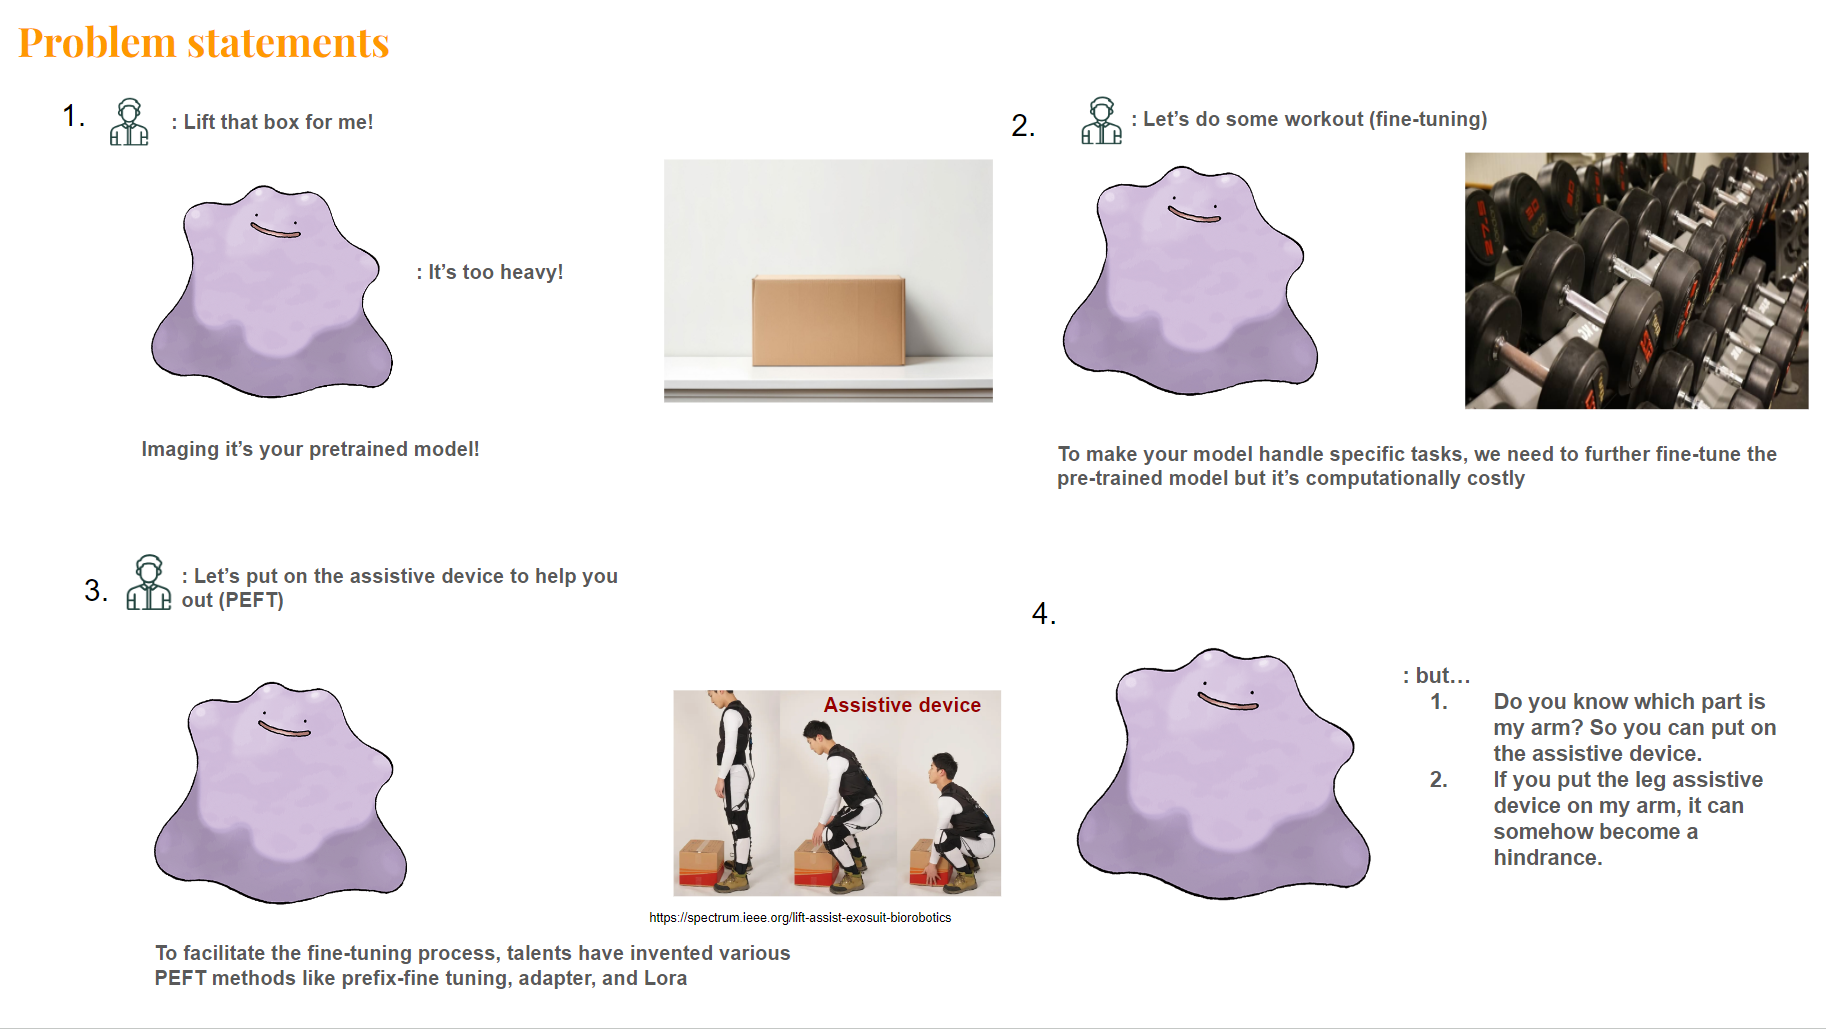

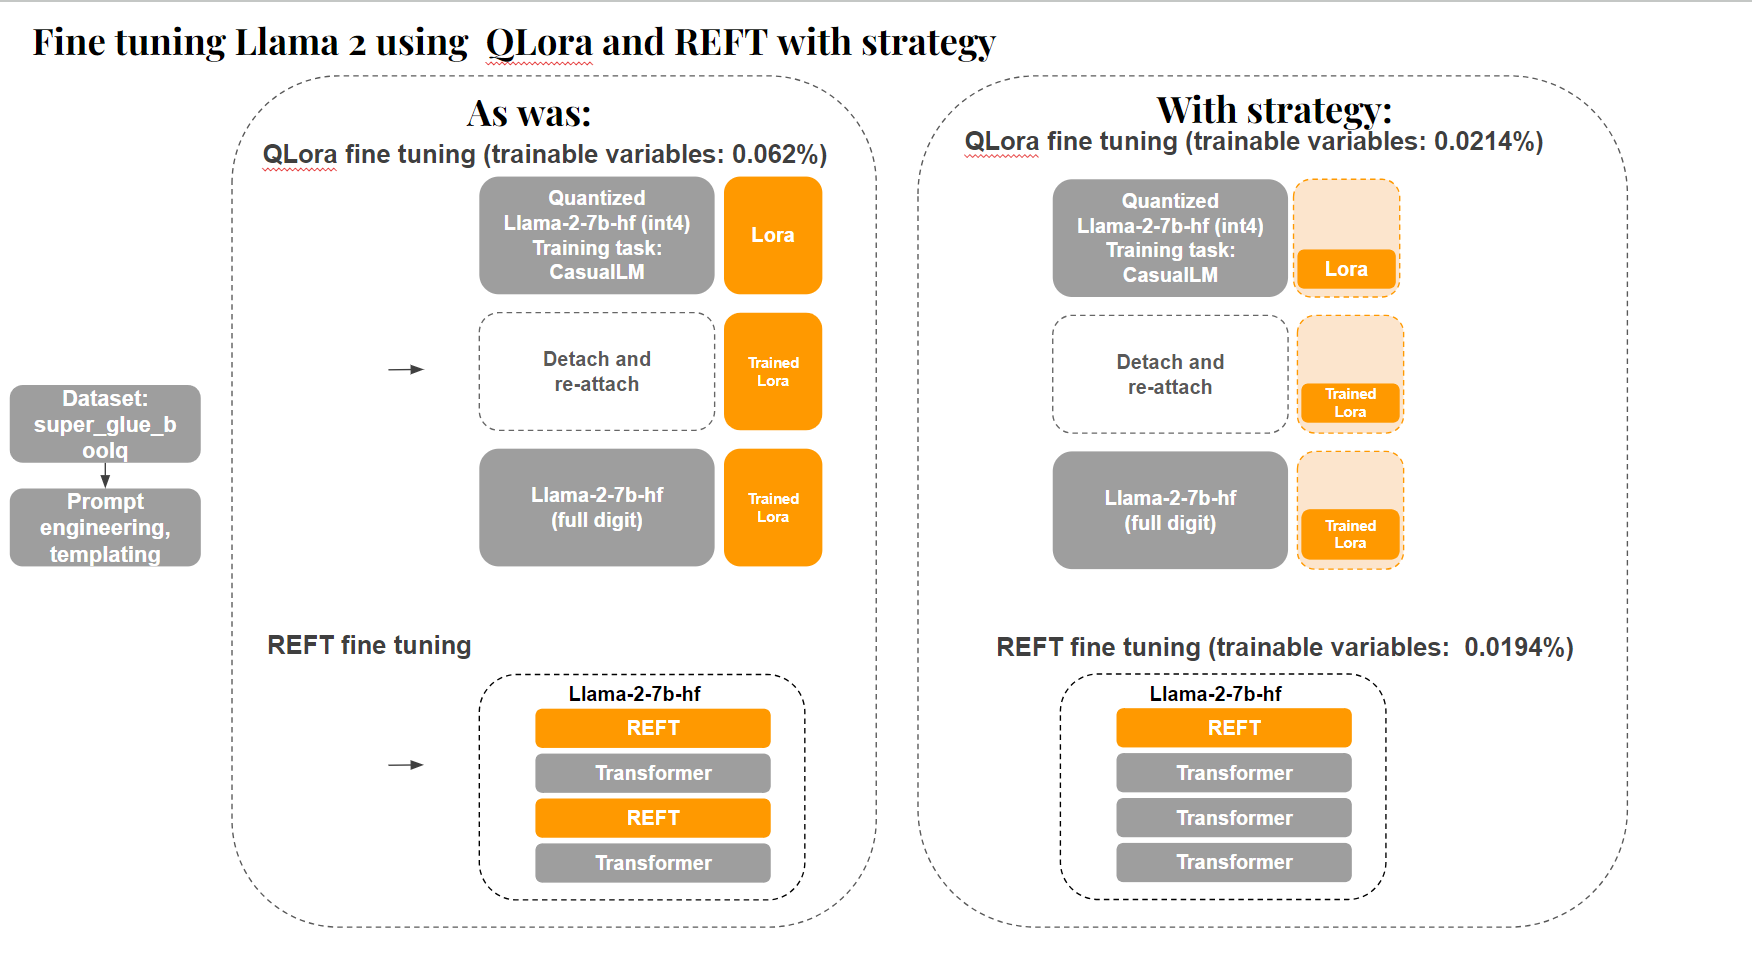

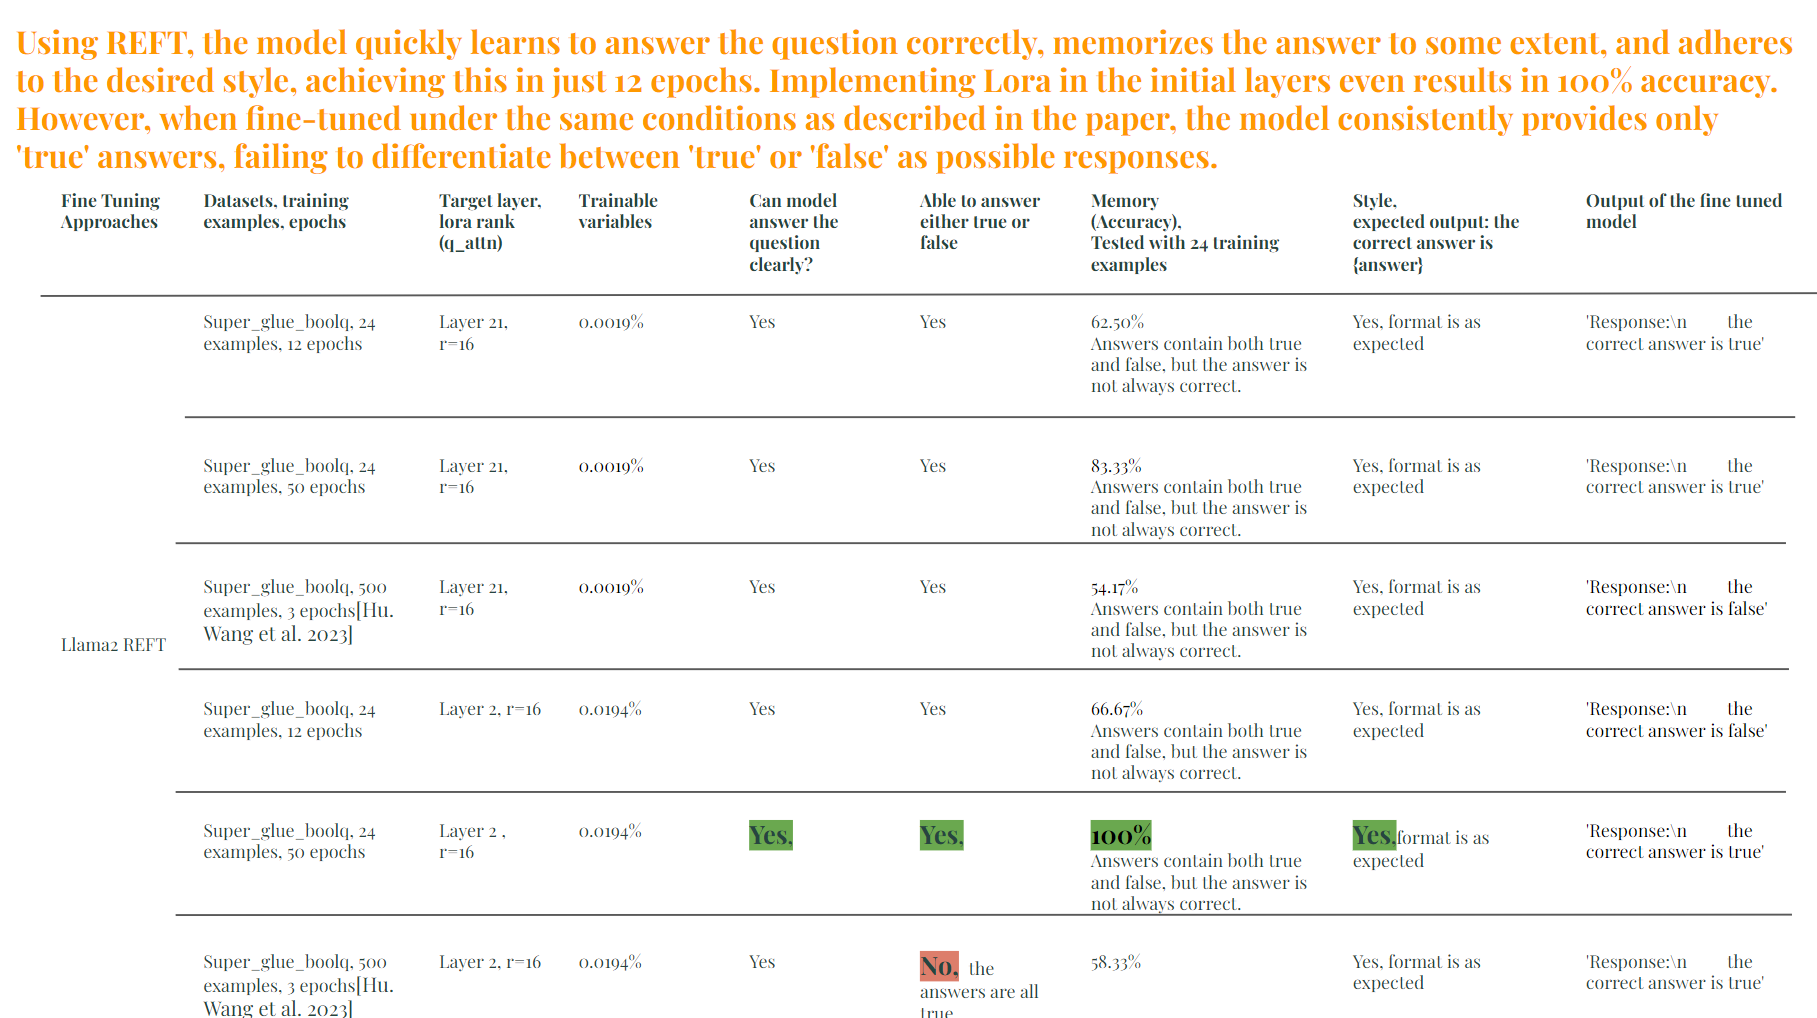

In [ ]:
import torch, transformers, pyreft
device = "cuda"


model_name_or_path = "NousResearch/Llama-2-7b-hf"
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.bfloat16, device_map=device)

# get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name_or_path, model_max_length=2048,
    padding_side="right", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
# get reft model
reft_config = pyreft.ReftConfig(representations={
    "layer": 2, "component": "block_output",
    "low_rank_dimension": 16,
    "intervention": pyreft.LoreftIntervention(embed_dim=model.config.hidden_size,
    low_rank_dimension=16)})
reft_model = pyreft.get_reft_model(model, reft_config)
reft_model.set_device("cuda")
reft_model.print_trainable_parameters()

# r = 16, layer = 21, trainable intervention params: 131,088 || trainable model params: 0 || model params: 6,738,415,616 || trainable%: 0.0019453831207552515
#  r = 16, layer = 2, trainable intervention params: 131,088 || trainable model params: 0 || model params: 6,738,415,616 || trainable%: 0.0019453831207552515
#  r = 16, layer = 15, trainable intervention params: 131,088 || trainable model params: 0 || model params: 6,738,415,616 || trainable%: 0.0019453831207552515

trainable intervention params: 131,088 || trainable model params: 0
model params: 6,738,415,616 || trainable%: 0.0019453831207552515


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# train subset
df = pd.read_csv('/content/drive/MyDrive/boolq_500.csv')
X = df['question'].iloc[:24].values
y = df['label_y'].iloc[:24].values

In [ ]:
def template_prompt_engineering(example):
  # add system template of Llama2 and prompt engineering for the boolq task
  example = f"""Please answer the following queation with true or false, question: {example}?\n\nAnswer format: true/false"""
  example = f"""<s>[INST]<<sys>>Below is an instruction that describes a task. Write a response that appropriately completes the request<</sys>>
        ### Instruction:
        {example}[/INST]

        ### Response:
        """
  return example

In [ ]:
data_module = pyreft.make_last_position_supervised_data_module(
    tokenizer,
    model,
    [template_prompt_engineering(x) for x in X],
    y
)

In [ ]:
# train
training_args = transformers.TrainingArguments(
    num_train_epochs=50, output_dir="./tmp", per_device_train_batch_size=10,
    learning_rate=4e-3, logging_steps=40, report_to=[])
trainer = pyreft.ReftTrainerForCausalLM(
    model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)
_ = trainer.train()

Step,Training Loss
40,0.516800
80,0.028200
120,0.000400


In [ ]:
reft_model.set_device("cpu") # send back to cpu before saving.
reft_model.save(
    save_directory="./reft_llama2",
)

Directory './reft_llama2' already exists.


In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.bfloat16, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
# # Load the reft model
reft_model = pyreft.ReftModel.load("./reft_llama2", model)
reft_model.set_device('cuda')

In [ ]:
def template_prompt_engineering(example):
  # add system template of Llama2 and prompt engineering for the boolq task
  example = f"""Please answer the following queation with true or false, question: {example}?\n\nAnswer format: true/false"""
  example = f"""<s>[INST]<<sys>>Below is an instruction that describes a task. Write a response that appropriately completes the request<</sys>>
        ### Instruction:
        {example}[/INST]

        ### Response:
        """
  return example

prompt = template_prompt_engineering("does ethanol take more energy make that produces?")
prompt = tokenizer(prompt, return_tensors='pt').to('cuda')

base_unit_location = prompt["input_ids"].shape[-1] - 1  # last position
_, reft_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_new_tokens=512, do_sample=True,
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
print(tokenizer.decode(reft_response[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


[INST]<<sys>>Below is an instruction that describes a task. Write a response that appropriately completes the request<</sys>>
        ### Instruction:
        Please answer the following queation with true or false, question: does ethanol take more energy make that produces??

Answer format: true/false[/INST]

        ### Response:
         the correct answer is true


In [ ]:
# inference
from tqdm.auto import tqdm
import numpy as np


predictions = []
for prompt in tqdm(df['question'][:24]):
    prompt = template_prompt_engineering(prompt)
    prompt = tokenizer(prompt, return_tensors='pt').to('cuda')
    base_unit_location = prompt["input_ids"].shape[-1] - 1  # last position
    _, reft_response = reft_model.generate(
        prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
        intervene_on_prompt=True, max_new_tokens=512, do_sample=True,
        eos_token_id=tokenizer.eos_token_id, early_stopping=True
    )
    result_text = tokenizer.decode(reft_response[0], skip_special_tokens=True)
    predictions.append(result_text[result_text.find('Response'):result_text.find('Response')+100])


def extract_boolean_label(text):
    text = text.lower()
    if 'true' in text:
        return 1
    elif 'false' in text:
        return 0
    else:
        return None

binary_predictions = []
for pred in predictions:
    binary_predictions.append(extract_boolean_label(pred))

binary_label = []
for label in df['label_y'][:24]:
    binary_label.append(extract_boolean_label(label))

# Calculate accuracy
accuracy = np.mean(np.array(binary_label) == np.array(binary_predictions))
print(f'Accuracy: {accuracy * 100:.2f}%')

  0%|          | 0/24 [00:00<?, ?it/s]

Accuracy: 100.00%


In [ ]:
predictions


#--high epochs: 50 / small dataset 24, expecting to memorize the answer and style
# 1 layer 21, r = 16, accuracy:83.33% trainable%: 0.0019453831207552515
# 2 layer 2, r = 16 , accuracy: 100% trainable%: 0.0019453831207552515

#1
# ['Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false']

#2
# ['Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false']




# 12 epochs (reft paper)
# 5 layer 21, r = 16, accuracy: 62.50% trainable%: 0.0019453831207552515
# 6 layer 2, r = 16, accuracy: 66.67% trainable%: 0.0019453831207552515


# 5
# ['Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true']

#6
# ['Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true']

# in the begining is better than in the end.. low sensitive is better than high sensitive..


['Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is false',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         

In [ ]:
predictions

# Reft,


# 3 epochs with 500 examples as training data
# 1 layer 21, r = 16, accuracy:54.17% trainable%: 0.0019453831207552515
# 2 layer 2, r = 16, accuracy:58.33% trainable%: 0.0019453831207552515 --all positive
# 3 layer 15, r = 16, accuracy:58.33% trainable%: 0.0019453831207552515 --all positive

# 1
# ['Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is false',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true']

#2
# ['Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true']

#3
# ['Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true',
#  'Response:\n         the correct answer is true']




# all true if the reft mounted on the begining layer
# the format is more close to expected format than Qlora
# accuracy is meaningless in this case.

['Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the correct answer is true',
 'Response:\n         the corre

In [ ]:
binary_label

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]